<a href="https://colab.research.google.com/github/kendraliu/Pneumonia-Prediction/blob/main/training_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
"""from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)"""

import pandas as pd
import numpy as np
import random
import cv2
import os
%matplotlib inline
from IPython.display import Image, SVG
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

/test: 234 normal, 390 pna

/val: 8 normal, 8 pna

/train: 1341 normal, 3875 pna

In [3]:
def normalArray(dataPath, dataImage, dataLabel):
    for filename in os.listdir(dataPath):
        img_path = os.path.join(dataPath, filename)
        image = cv2.imread(img_path)
        image = cv2.resize(image, (224, 224))  # Resize to a common size
        image = image / 255.0  # Normalize pixel values to [0, 1]
        dataImage.append(image)
        dataLabel.append(0)
    dataImage = np.array(dataImage)
    dataLabel = np.array(dataLabel)
    return dataImage, dataLabel

In [4]:
def pnaArray(dataPath, dataImage, dataLabel):
    for filename in os.listdir(dataPath):
        img_path = os.path.join(dataPath, filename)
        image = cv2.imread(img_path)
        image = cv2.resize(image, (224, 224))  # Resize to a common size
        image = image / 255.0  # Normalize pixel values to [0, 1]
        dataImage.append(image)
        dataLabel.append(1)
    dataImage = np.array(dataImage)
    dataLabel = np.array(dataLabel)
    return dataImage, dataLabel

In [5]:
def valHistory(model, fit):
    val_loss, val_accuracy = model.evaluate(X_val, y_val)
    print("Validation Loss:", val_loss)
    print("Validation Accuracy:", val_accuracy)

    history_df = pd.DataFrame(fit.history)
    history_df.index += 1  # Increase the index by 1 to match the number of epochs

    # Plot accuracy and loss history
    history_df.plot(y="accuracy")
    plt.title("Accuracy History")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()

    history_df.plot(y="loss")
    plt.title("Loss History")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

In [6]:
def dnnEval(fit, X_val, y_val):
    dnn_predict = fit.predict(X_val)
    dnn_predict_classes = (dnn_predict > 0.5).astype(int)

    # Calculate and print metrics
    accuracy = accuracy_score(y_val, dnn_predict_classes)
    print("Accuracy:", accuracy)

    cm = confusion_matrix(y_val, dnn_predict_classes)
    tp = cm[1][1] / (cm[1][1] + cm[1][0])
    fn = cm[1][0] / (cm[1][1] + cm[1][0])
    fp = cm[0][1] / (cm[1][1] + cm[0][1])
    tn = cm[0][0] / (cm[0][0] + cm[0][1])

    print("Confusion Matrix:")
    print(cm)

    print("Classification Report:")
    print(classification_report(y_val, dnn_predict_classes))

    fitSummary = pd.DataFrame({
    "accuracy": [accuracy],
    "true_positive": [tp],
    "false_negative": [fn],
    "false positive": [fp],
    "true_negative": [tn]
    })
    print(fitSummary)


In [7]:
!pwd

/content


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
testNormal = "drive/MyDrive/Pneumonia-Prediction/chest_xray/test/NORMAL"
testPNA = "drive/MyDrive/Pneumonia-Prediction/chest_xray/test/PNEUMONIA"
valNormal = "drive/MyDrive/Pneumonia-Prediction/chest_xray/val/NORMAL"
valPNA = "drive/MyDrive/Pneumonia-Prediction/chest_xray/val/PNEUMONIA"
trainNormal = "drive/MyDrive/Pneumonia-Prediction/chest_xray/train/NORMAL"
trainPNA1 = "drive/MyDrive/Pneumonia-Prediction/chest_xray/train/PNEUMONIA1"
#trainPNA2 = "drive/MyDrive/Pneumonia-Prediction/chest_xray/train/PNEUMONIA2"
#trainPNA3 = "drive/MyDrive/Pneumonia-Prediction/chest_xray/train/PNEUMONIA3"

In [10]:
os.listdir(valNormal) #check to see there's no random ".DS_Store" in directory
# if there is, run: find . -name ".DS_Store" -type f -delete
# or just run it anyway to be safe

['NORMAL2-IM-1440-0001.jpeg',
 'NORMAL2-IM-1438-0001.jpeg',
 'NORMAL2-IM-1431-0001.jpeg',
 'NORMAL2-IM-1427-0001.jpeg',
 'NORMAL2-IM-1437-0001.jpeg',
 'NORMAL2-IM-1442-0001.jpeg',
 'NORMAL2-IM-1436-0001.jpeg',
 'NORMAL2-IM-1430-0001.jpeg']

In [11]:
# images are X, labels are y
testNormalimage = []
testNormalLabel = []
testPNAimage = []
testPNALabel = []
valNormalimage = []
valNormalLabel = []
valPNAimage = []
valPNALabel = []
trainNormalimage = []
trainNormalLabel = []
trainPNAimage1 = []
trainPNALabel1= []


In [12]:
trainNormalimage, trainNormalLabel = normalArray(trainNormal, trainNormalimage, trainNormalLabel)
trainNormalimage.shape

(1341, 224, 224, 3)

In [13]:
trainPNAimage1, trainPNALabel1 = pnaArray(trainPNA1, trainPNAimage1, trainPNALabel1)
trainPNAimage1.shape

(1307, 224, 224, 3)

In [14]:
X_train = np.concatenate((trainNormalimage, trainPNAimage1), axis=0)
X_train.shape

(2648, 224, 224, 3)

In [15]:
y_train = np.concatenate((trainNormalLabel, trainPNALabel1), axis=0)
y_train

array([0, 0, 0, ..., 1, 1, 1])

In [16]:
y_train.shape

(2648,)

In [17]:
valNormalimage, valNormalLabel = normalArray(valNormal, valNormalimage, valNormalLabel)
valNormalimage.shape

(8, 224, 224, 3)

In [18]:
valPNAimage, valPNALabel = pnaArray(valPNA, valPNAimage, valPNALabel)
valPNAimage.shape

(8, 224, 224, 3)

In [19]:
valPNALabel

array([1, 1, 1, 1, 1, 1, 1, 1])

In [20]:
X_val = np.concatenate((valNormalimage, valPNAimage), axis=0)
#X_val

In [21]:
y_val = np.concatenate((valNormalLabel, valPNALabel), axis=0)
y_val

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])

In [22]:
testNormalimage, testNormalLabel = normalArray(testNormal, testNormalimage, testNormalLabel)
testNormalimage.shape

(234, 224, 224, 3)

In [23]:
testPNAimage, testPNALabel = pnaArray(testPNA, testPNAimage, testPNALabel)
testPNAimage.shape

(390, 224, 224, 3)

In [24]:
X_test = np.concatenate((testNormalimage, testPNAimage), axis=0)
X_test.shape

(624, 224, 224, 3)

In [25]:
y_test = np.concatenate((testNormalLabel, testPNALabel), axis=0)
y_test.shape

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

resplit

In [26]:
combinedValTestNormalImage = np.concatenate((valNormalimage, testNormalimage), axis=0)
combinedValTestPNAImage = np.concatenate((valPNAimage, testPNAimage), axis=0)
combinedValTestNormalLabel = np.concatenate((valNormalLabel, testNormalLabel), axis=0)
combinedValTestPNALabel = np.concatenate((valPNALabel, testPNALabel), axis=0)
combinedXValTest = np.concatenate((combinedValTestNormalImage, combinedValTestPNAImage), axis=0)
combinedyValTest = np.concatenate((combinedValTestNormalLabel, combinedValTestPNALabel), axis=0)
X_val40, X_test60, y_val40, y_test60 = train_test_split(combinedXValTest, combinedyValTest, test_size=0.6, random_state=42)
print(X_val40.shape)
print(X_test60.shape)
print(y_val40.shape)
print(y_test60.shape)

(256, 224, 224, 3)
(384, 224, 224, 3)
(256,)
(384,)


In [27]:
#test
random_index = random.sample(range(len(X_test60)), 160)
X_test60_sampled = np.array([X_test60[i] for i in random_index])
y_test60_sampled = np.array([y_test60[i] for i in random_index])
print(X_test60_sampled.shape)
print(X_test60.shape)

(160, 224, 224, 3)
(384, 224, 224, 3)


In [28]:
#val
random_index = random.sample(range(len(X_val40)), 120)
X_val_sampled = np.array([X_val40[i] for i in random_index])
y_val_sampled = np.array([y_val40[i] for i in random_index])
print(X_val_sampled.shape)
print(y_val_sampled)

(120, 224, 224, 3)
[1 1 1 1 1 1 0 0 1 1 1 1 0 1 0 1 1 0 1 0 0 0 1 1 0 1 1 1 0 1 1 0 1 1 1 1 0
 1 0 0 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 1 1 0 1 1 1 1 0 1 1 1 1
 1 0 0 0 0 0 0 0 1 1 1 0 1 0 0 1 1 1 0 1 0 0 0 1 1 1 0 1 1 1 1 1 0 0 1 0 1
 0 1 1 0 0 1 1 0 0]


In [ ]:
random_index = random.sample(range(len(X_train)), 500)
X_train_sampled = np.array([X_train[i] for i in random_index])
y_train_sampled = np.array([y_train[i] for i in random_index])
print(X_train_sampled.shape)
print(y_train_sampled.shape)

In [ ]:
X_train_sampled_reshaped = X_train_sampled.reshape(X_train_sampled.shape[0], -1)
print(X_train_sampled_reshaped.shape)

X_val_sampled_reshaped = X_val_sampled.reshape(X_val_sampled.shape[0], -1)
print(X_val_sampled_reshaped.shape)

X_test_sampled_reshaped = X_test_sampled.reshape(X_test_sampled.shape[0], -1)
print(X_test_sampled_reshaped.shape)

# DNN

In [ ]:
dnnModel = tf.keras.models.Sequential()

In [ ]:
#testing nn
dnnModel.add(tf.keras.layers.Dense(units=35, activation=tf.keras.layers.LeakyReLU(alpha=0.2), input_dim=150528))
dnnModel.add(tf.keras.layers.Dense(units=12, activation=tf.keras.layers.LeakyReLU(alpha=0.2)))
dnnModel.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

In [ ]:
print(X_train_sampled_reshaped.shape)
print(X_val_sampled_reshaped.shape)
print(X_test_sampled_reshaped.shape)
print(dnnModel.summary())

dnnModel.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

fit7 = dnnModel.fit(X_train_sampled_reshaped, y_train_sampled, epochs=100) #train/val: 300/60

Model: "sequential_8"
		_________________________________________________________________
		 Layer (type)                Output Shape              Param #   
		=================================================================
		 dense_31 (Dense)            (None, 35)                5268515   
		                                                                 
		 dense_32 (Dense)            (None, 12)                432       
		                                                                 
		 dense_33 (Dense)            (None, 1)                 13        
		                                                                 
		=================================================================
		Total params: 5,268,960
		Trainable params: 5,268,960
		Non-trainable params: 0
		_________________________________________________________________


4/4 [==============================] - 0s 17ms/step - loss: 2.1035 - accuracy: 0.7750
Validation Loss: 2.1035192012786865
Validation Accuracy: 0.7749999761581421


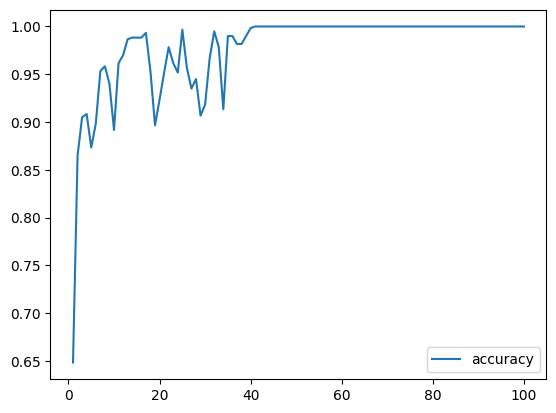

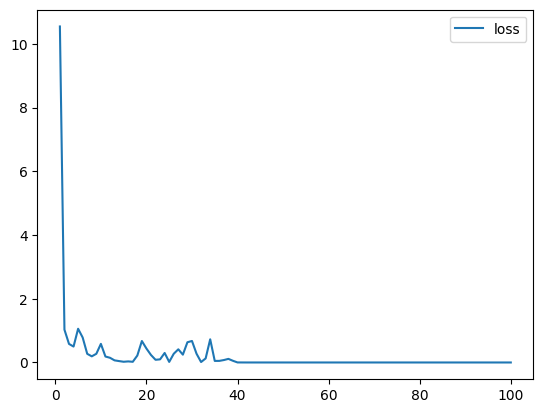

4/4 [==============================] - 0s 19ms/step
Accuracy: 0.775
Confusion Matrix:
[[21 21]
 [ 6 72]]
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.50      0.61        42
           1       0.77      0.92      0.84        78

    accuracy                           0.78       120
   macro avg       0.78      0.71      0.73       120
weighted avg       0.78      0.78      0.76       120



,acuuracy1,loss:,true_positive,false_negative,false_positive,true_negative
0,0.775,2.103519,0.923077,0.076923,0.225806,0.5


In [145]:
val_loss, val_accuracy = dnnModel.evaluate(X_val_sampled_reshaped, y_val_sampled)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

history_df = pd.DataFrame(fit7.history)
history_df.index += 1 # Increase the index by 1 to match the number of epochs
history_df.plot(y="accuracy")
plt.show()

history_df.plot(y="loss")
plt.show()

fit7Predict = dnnModel.predict(X_val_sampled_reshaped)
fit7PredictClass = (fit7Predict > 0.5).astype(int)
print("Accuracy:", accuracy_score(y_val_sampled, fit7PredictClass))
print("Confusion Matrix:")
print(confusion_matrix(y_val_sampled, fit7PredictClass))
print("Classification Report:")
print(classification_report(y_val_sampled, fit7PredictClass))
fit7TP = []
fit7FN = []
fit7FP = []
fit7TN = []
cm = confusion_matrix(y_val_sampled, fit7PredictClass)
fit7TP.append(cm[1][1]/(cm[1][1]+cm[1][0]))
fit7FN.append(cm[1][0]/(cm[1][1]+cm[1][0]))
fit7FP.append(cm[0][1]/(cm[1][1]+cm[0][1]))
fit7TN.append(cm[0][0]/(cm[0][0]+cm[0][1]))

fit7Summary = pd.DataFrame({"acuuracy": val_accuracy, "loss:": val_loss, "true_positive": fit7TP, "false_negative": fit7FN, "false_positive": fit7FP, "true_negative": fit7TN})
fit7Summary

In [107]:
"""print(dnnModel.summary())
dnnModel.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])""" #training/val: 150/30

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 15)                2257935   
                                                                 
 dense_23 (Dense)            (None, 7)                 112       
                                                                 
 dense_24 (Dense)            (None, 1)                 8         
                                                                 
Total params: 2,258,055
Trainable params: 2,258,055
Non-trainable params: 0
_________________________________________________________________
None


In [108]:
fit6 = dnnModel.fit(X_train_sampled_reshaped, y_train_sampled, epochs=100)

Epoch 1/100
5/5 [==============================] - 1s 63ms/step - loss: 32.0986 - accuracy: 0.5533
Epoch 2/100
5/5 [==============================] - 0s 59ms/step - loss: 3.1482 - accuracy: 0.5133
Epoch 3/100
5/5 [==============================] - 0s 54ms/step - loss: 1.3632 - accuracy: 0.6200
Epoch 4/100
5/5 [==============================] - 0s 60ms/step - loss: 0.8814 - accuracy: 0.6200
Epoch 5/100
5/5 [==============================] - 0s 58ms/step - loss: 0.7865 - accuracy: 0.6867
Epoch 6/100
5/5 [==============================] - 0s 52ms/step - loss: 0.7127 - accuracy: 0.7000
Epoch 7/100
5/5 [==============================] - 0s 57ms/step - loss: 0.5173 - accuracy: 0.7800
Epoch 8/100
5/5 [==============================] - 0s 56ms/step - loss: 0.3993 - accuracy: 0.8400
Epoch 9/100
5/5 [==============================] - 0s 55ms/step - loss: 0.3753 - accuracy: 0.8333
Epoch 10/100
5/5 [==============================] - 0s 58ms/step - loss: 0.2637 - accuracy: 0.9200
Epoch 11/100
5/5 [

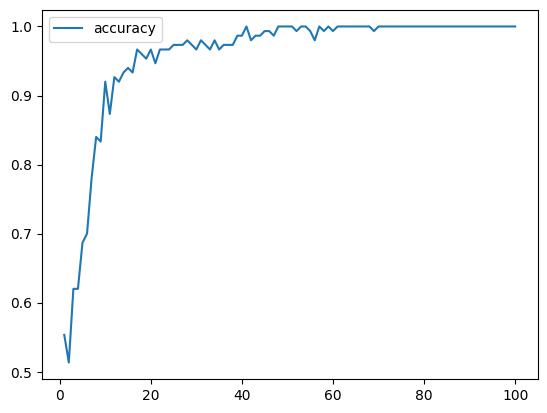

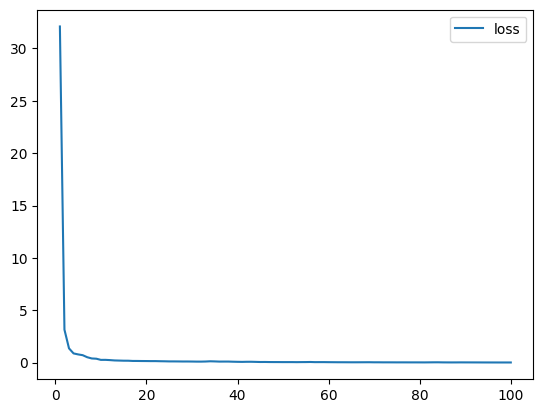

In [111]:
history_df = pd.DataFrame(fit6.history)
history_df.index += 1 # Increase the index by 1 to match the number of epochs
history_df.plot(y="accuracy")
plt.show()

history_df.plot(y="loss")
plt.show()

In [109]:
val_loss, val_accuracy = dnnModel.evaluate(X_val_sampled_reshaped, y_val_sampled)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

1/1 [==============================] - 1s 738ms/step - loss: 0.2440 - accuracy: 0.9000
Validation Loss: 0.2440192550420761
Validation Accuracy: 0.8999999761581421


In [112]:
fit6Predict = dnnModel.predict(X_val_sampled_reshaped)
fit6PredictClass = (fit6Predict > 0.5).astype(int)
print("Accuracy:", accuracy_score(y_val_sampled, fit6PredictClass))
print("Confusion Matrix:")
print(confusion_matrix(y_val_sampled, fit6PredictClass))
print("Classification Report:")
print(classification_report(y_val_sampled, fit6PredictClass))
fit6TP = []
fit6FN = []
fit6FP = []
fit6TN = []
cm = confusion_matrix(y_val_sampled, fit6PredictClass)
fit6TP.append(cm[1][1]/(cm[1][1]+cm[1][0]))
fit6FN.append(cm[1][0]/(cm[1][1]+cm[1][0]))
fit6FP.append(cm[0][1]/(cm[1][1]+cm[0][1]))
fit6TN.append(cm[0][0]/(cm[0][0]+cm[0][1]))

fit6Summary = pd.DataFrame({"acuuracy1": val_accuracy, "loss:": val_loss, "true_positive": fit6TP, "false_negative": fit6FN, "false_positive": fit6FP, "true_negative": fit6TN})
fit6Summary

1/1 [==============================] - 0s 112ms/step
Accuracy: 0.9
Confusion Matrix:
[[ 7  2]
 [ 1 20]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.78      0.82         9
           1       0.91      0.95      0.93        21

    accuracy                           0.90        30
   macro avg       0.89      0.87      0.88        30
weighted avg       0.90      0.90      0.90        30



,acuuracy1,loss:,true_positive,false_negative,false_positive,true_negative
0,0.9,0.244019,0.952381,0.047619,0.090909,0.777778


In [133]:
val_loss, val_accuracy = dnnModel.evaluate(X_test_sampled_reshaped, y_test_sampled)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

NameError: ignored

In [97]:
"""print(dnnModel.summary())
dnnModel.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])""" #train/val: 80/16

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 10)                1505290   
                                                                 
 dense_20 (Dense)            (None, 5)                 55        
                                                                 
 dense_21 (Dense)            (None, 1)                 6         
                                                                 
Total params: 1,505,351
Trainable params: 1,505,351
Non-trainable params: 0
_________________________________________________________________
None


In [98]:
fit5 = dnnModel.fit(X_train_sampled_reshaped, y_train_sampled, epochs=100)

Epoch 1/100
5/5 [==============================] - 2s 85ms/step - loss: 25.7459 - accuracy: 0.5267
Epoch 2/100
5/5 [==============================] - 0s 78ms/step - loss: 7.3819 - accuracy: 0.5200
Epoch 3/100
5/5 [==============================] - 0s 83ms/step - loss: 3.4776 - accuracy: 0.5267
Epoch 4/100
5/5 [==============================] - 0s 87ms/step - loss: 1.0900 - accuracy: 0.6400
Epoch 5/100
5/5 [==============================] - 0s 77ms/step - loss: 0.5810 - accuracy: 0.8067
Epoch 6/100
5/5 [==============================] - 0s 74ms/step - loss: 0.4790 - accuracy: 0.8000
Epoch 7/100
5/5 [==============================] - 0s 67ms/step - loss: 0.4939 - accuracy: 0.8333
Epoch 8/100
5/5 [==============================] - 0s 64ms/step - loss: 0.4047 - accuracy: 0.8333
Epoch 9/100
5/5 [==============================] - 0s 62ms/step - loss: 0.3674 - accuracy: 0.8600
Epoch 10/100
5/5 [==============================] - 0s 64ms/step - loss: 0.2624 - accuracy: 0.9000
Epoch 11/100
5/5 [

In [99]:
val_loss, val_accuracy = dnnModel.evaluate(X_val_sampled_reshaped, y_val_sampled)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

1/1 [==============================] - 0s 273ms/step - loss: 0.2557 - accuracy: 0.8667
Validation Loss: 0.2557065188884735
Validation Accuracy: 0.8666666746139526


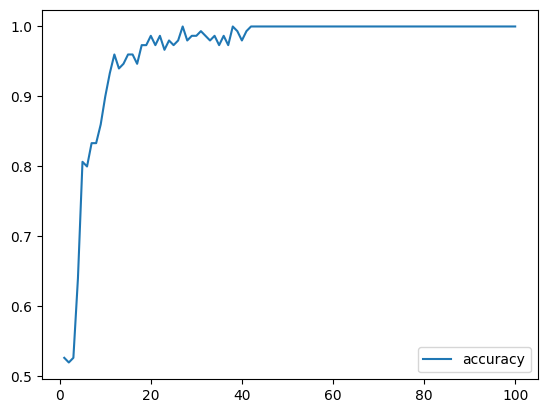

In [100]:
history_df = pd.DataFrame(fit5.history)
history_df.index += 1 # Increase the index by 1 to match the number of epochs
history_df.plot(y="accuracy")
plt.show()

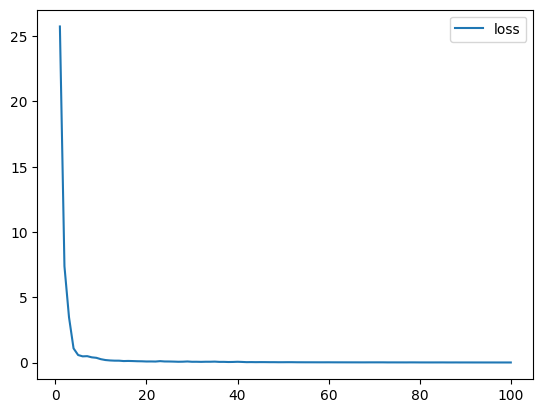

In [101]:
history_df.plot(y="loss")
plt.show()

In [102]:
fit5Predict = dnnModel.predict(X_val_sampled_reshaped)
fit5PredictClass = (fit5Predict > 0.5).astype(int)
print("Accuracy:", accuracy_score(y_val_sampled, fit5PredictClass))
print("Confusion Matrix:")
print(confusion_matrix(y_val_sampled, fit5PredictClass))
print("Classification Report:")
print(classification_report(y_val_sampled, fit5PredictClass))
fit5TP = []
fit5FN = []
fit5FP = []
fit5TN = []
cm = confusion_matrix(y_val_sampled, fit5PredictClass)
fit5TP.append(cm[1][1]/(cm[1][1]+cm[1][0]))
fit5FN.append(cm[1][0]/(cm[1][1]+cm[1][0]))
fit5FP.append(cm[0][1]/(cm[1][1]+cm[0][1]))
fit5TN.append(cm[0][0]/(cm[0][0]+cm[0][1]))

1/1 [==============================] - 0s 140ms/step
Accuracy: 0.8666666666666667
Confusion Matrix:
[[ 7  2]
 [ 2 19]]
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.78      0.78         9
           1       0.90      0.90      0.90        21

    accuracy                           0.87        30
   macro avg       0.84      0.84      0.84        30
weighted avg       0.87      0.87      0.87        30



In [104]:
fit5Summary = pd.DataFrame({"acuuracy1": val_accuracy, "loss:": val_loss, "true_positive": fit5TP, "false_negative": fit5FN, "false_positive": fit5FP, "true_negative": fit5TN})
fit5Summary

,acuuracy1,loss:,true_positive,false_negative,false_positive,true_negative
0,0.866667,0.255707,0.904762,0.095238,0.095238,0.777778


In [63]:
"""dnnModel.summary()""" #training/val: 80/16

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 5)                 752645    
                                                                 
 dense_17 (Dense)            (None, 2)                 12        
                                                                 
 dense_18 (Dense)            (None, 1)                 3         
                                                                 
Total params: 752,660
Trainable params: 752,660
Non-trainable params: 0
_________________________________________________________________


In [64]:
dnnModel.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [65]:
fit4 = dnnModel.fit(X_train_sampled_reshaped, y_train_sampled, epochs=100)

Epoch 1/100
3/3 [==============================] - 1s 58ms/step - loss: 5.3252 - accuracy: 0.4875
Epoch 2/100
3/3 [==============================] - 0s 48ms/step - loss: 5.1127 - accuracy: 0.5500
Epoch 3/100
3/3 [==============================] - 0s 45ms/step - loss: 3.3796 - accuracy: 0.4750
Epoch 4/100
3/3 [==============================] - 0s 47ms/step - loss: 1.4479 - accuracy: 0.6000
Epoch 5/100
3/3 [==============================] - 0s 74ms/step - loss: 1.9587 - accuracy: 0.5250
Epoch 6/100
3/3 [==============================] - 0s 52ms/step - loss: 0.7089 - accuracy: 0.6125
Epoch 7/100
3/3 [==============================] - 0s 60ms/step - loss: 1.0508 - accuracy: 0.4875
Epoch 8/100
3/3 [==============================] - 0s 50ms/step - loss: 0.6322 - accuracy: 0.6250
Epoch 9/100
3/3 [==============================] - 0s 50ms/step - loss: 0.4865 - accuracy: 0.7500
Epoch 10/100
3/3 [==============================] - 0s 49ms/step - loss: 0.4385 - accuracy: 0.8000
Epoch 11/100
3/3 [=

In [66]:
val_loss, val_accuracy = dnnModel.evaluate(X_val_sampled_reshaped, y_val_sampled)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

1/1 [==============================] - 1s 639ms/step - loss: 0.3641 - accuracy: 0.8750
Validation Loss: 0.36411744356155396
Validation Accuracy: 0.875


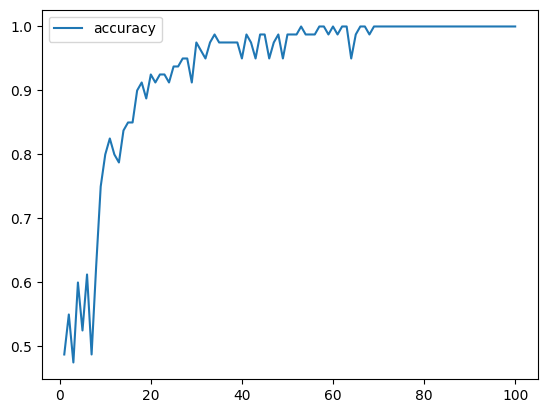

In [69]:
history_df = pd.DataFrame(fit4.history)
history_df.index += 1 # Increase the index by 1 to match the number of epochs
history_df.plot(y="accuracy")
plt.show()

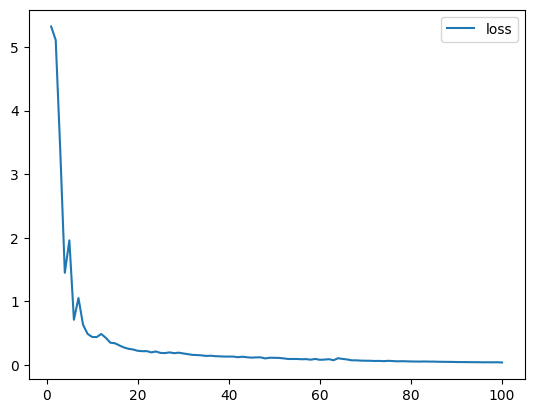

In [68]:
history_df.plot(y="loss")
plt.show()

In [70]:
fit4Predict = dnnModel.predict(X_val_sampled_reshaped)
fit4PredictClass = (fit4Predict > 0.5).astype(int)
print("Accuracy:", accuracy_score(y_val_sampled, fit4PredictClass))
print("Confusion Matrix:")
print(confusion_matrix(y_val_sampled, fit4PredictClass))
print("Classification Report:")
print(classification_report(y_val_sampled, fit4PredictClass))

1/1 [==============================] - 0s 373ms/step
Accuracy: 0.875
Confusion Matrix:
[[6 2]
 [0 8]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.80      1.00      0.89         8

    accuracy                           0.88        16
   macro avg       0.90      0.88      0.87        16
weighted avg       0.90      0.88      0.87        16



In [71]:
fit4TP = []
fit4FN = []
fit4FP = []
fit4TN = []
cm = confusion_matrix(y_val_sampled, fit4PredictClass)
fit4TP.append(cm[1][1]/(cm[1][1]+cm[1][0]))
fit4FN.append(cm[1][0]/(cm[1][1]+cm[1][0]))
fit4FP.append(cm[0][1]/(cm[1][1]+cm[0][1]))
fit4TN.append(cm[0][0]/(cm[0][0]+cm[0][1]))

In [73]:
fit4Summary = pd.DataFrame({"acuuracy1": val_accuracy, "loss:": val_loss, "true_positive": fit4TP, "false_negative": fit4FN, "false_positive": fit4FP, "true_negative": fit4TN})
fit4Summary

,acuuracy1,loss:,true_positive,false_negative,false_positive,true_negative
0,0.875,0.364117,1.0,0.0,0.2,0.75


In [49]:
"""dnnModel.summary()""" #training: 80/16

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 5)                 752645    
                                                                 
 dense_9 (Dense)             (None, 2)                 12        
                                                                 
 dense_10 (Dense)            (None, 1)                 3         
                                                                 
Total params: 752,660
Trainable params: 752,660
Non-trainable params: 0
_________________________________________________________________


In [47]:
"""fit3 = dnnModel.fit(X_train_sampled_reshaped, y_train_sampled, epochs=100)"""

Epoch 1/100
3/3 [==============================] - 1s 38ms/step - loss: 0.6932 - accuracy: 0.4000
Epoch 2/100
3/3 [==============================] - 0s 41ms/step - loss: 0.6932 - accuracy: 0.4500
Epoch 3/100
3/3 [==============================] - 0s 42ms/step - loss: 0.6931 - accuracy: 0.5250
Epoch 4/100
3/3 [==============================] - 0s 34ms/step - loss: 0.6931 - accuracy: 0.5250
Epoch 5/100
3/3 [==============================] - 0s 49ms/step - loss: 0.6931 - accuracy: 0.5250
Epoch 6/100
3/3 [==============================] - 0s 36ms/step - loss: 0.6931 - accuracy: 0.5250
Epoch 7/100
3/3 [==============================] - 0s 37ms/step - loss: 0.6930 - accuracy: 0.5250
Epoch 8/100
3/3 [==============================] - 0s 39ms/step - loss: 0.6930 - accuracy: 0.5250
Epoch 9/100
3/3 [==============================] - 0s 39ms/step - loss: 0.6930 - accuracy: 0.5250
Epoch 10/100
3/3 [==============================] - 0s 35ms/step - loss: 0.6930 - accuracy: 0.5250
Epoch 11/100
3/3 [=

In [48]:
"""val_loss, val_accuracy = dnnModel.evaluate(X_val_sampled_reshaped, y_val_sampled)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)"""

1/1 [==============================] - 0s 233ms/step - loss: 0.6936 - accuracy: 0.5000
Validation Loss: 0.69364994764328
Validation Accuracy: 0.5


In [36]:
"""fit2 = dnnModel.fit(X_train_sampled_reshaped, y_train_sampled, epochs=100)""" # increase data size from 8/2 to 40/10

Epoch 1/100
2/2 [==============================] - 1s 37ms/step - loss: 0.6724 - accuracy: 0.5250
Epoch 2/100
2/2 [==============================] - 0s 33ms/step - loss: 0.6932 - accuracy: 0.4750
Epoch 3/100
2/2 [==============================] - 0s 30ms/step - loss: 0.6932 - accuracy: 0.4750
Epoch 4/100
2/2 [==============================] - 0s 27ms/step - loss: 0.6932 - accuracy: 0.4750
Epoch 5/100
2/2 [==============================] - 0s 24ms/step - loss: 0.6932 - accuracy: 0.4750
Epoch 6/100
2/2 [==============================] - 0s 29ms/step - loss: 0.6931 - accuracy: 0.5250
Epoch 7/100
2/2 [==============================] - 0s 24ms/step - loss: 0.6931 - accuracy: 0.5250
Epoch 8/100
2/2 [==============================] - 0s 24ms/step - loss: 0.6931 - accuracy: 0.5250
Epoch 9/100
2/2 [==============================] - 0s 24ms/step - loss: 0.6931 - accuracy: 0.5250
Epoch 10/100
2/2 [==============================] - 0s 39ms/step - loss: 0.6931 - accuracy: 0.5250
Epoch 11/100
2/2 [=

In [38]:
"""val_loss, val_accuracy = dnnModel.evaluate(X_val_sampled_reshaped, y_val_sampled)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)"""

1/1 [==============================] - 0s 41ms/step - loss: 0.6933 - accuracy: 0.5000
Validation Loss: 0.6932926177978516
Validation Accuracy: 0.5


In [26]:
"""fit1 = dnnModel.fit(X_train_sampled_reshaped, y_train_sampled, epochs=100)""" #2, 1: relu, sigmoid

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 1.5097 - accuracy: 0.2500
Epoch 2/100
1/1 [==============================] - 0s 24ms/step - loss: 0.6929 - accuracy: 0.7500
Epoch 3/100
1/1 [==============================] - 0s 32ms/step - loss: 0.6927 - accuracy: 0.7500
Epoch 4/100
1/1 [==============================] - 0s 39ms/step - loss: 0.6925 - accuracy: 0.7500
Epoch 5/100
1/1 [==============================] - 0s 36ms/step - loss: 0.6922 - accuracy: 0.7500
Epoch 6/100
1/1 [==============================] - 0s 25ms/step - loss: 0.6920 - accuracy: 0.7500
Epoch 7/100
1/1 [==============================] - 0s 31ms/step - loss: 0.6918 - accuracy: 0.7500
Epoch 8/100
1/1 [==============================] - 0s 29ms/step - loss: 0.6916 - accuracy: 0.7500
Epoch 9/100
1/1 [==============================] - 0s 25ms/step - loss: 0.6914 - accuracy: 0.7500
Epoch 10/100
1/1 [==============================] - 0s 27ms/step - loss: 0.6911 - accuracy: 0.7500
Epoch 11/100
1/1 [===

In [29]:
# Evaluate the model on validation data
"""val_loss, val_accuracy = dnnModel.evaluate(X_val_sampled_reshaped, y_val_sampled)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)"""


1/1 [==============================] - 0s 330ms/step - loss: 0.6942 - accuracy: 0.5000
Validation Loss: 0.6942259669303894
Validation Accuracy: 0.5
